# Introduction

This example gives a simple demostration of chaotic behavior in a simple two body system. The system is made up of a slender rod that is connected to the ceiling at one end with a revolute joint that rotates about the $\hat{\mathbf{n}}_y$ unit vector. At the other end of the rod a flat plate is attached via a second revolute joint allowing the plate to rotate about the rod's axis with aligns with the $\hat{\mathbf{a}_z}$ unit vector.

![]( https://objects-us-east-1.dream.io/mae223/2019f/chaos_pendulum.png )

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
from pydy.viz import Cylinder, Plane, VisualizationFrame, Scene
import pythreejs as pjs

/home/moorepants/src/pydy/pydy/viz/scene.py:56: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import CFloat, List


In [2]:
me.init_vprinting()

# Define Variables

First define the system constants:

- $m_A$: Mass of the slender rod.
- $m_B$: Mass of the plate.
- $l_B$: Distance from $N_o$ to $B_o$ along the slender rod's axis.
- $w$: The width of the plate.
- $h$: The height of the plate.
- $g$: The acceleratoin due to gravity.

In [3]:
mA, mB, lB, w, h, g = sm.symbols('m_A, m_B, L_B, w, h, g')

There are two time varying generalized coordinates:

- $\theta(t)$: The angle of the slender rod with respect to the ceiling.
- $\phi(t)$: The angle of the plate with respect to the slender rod.

The two generalized speeds will then be defined as:

- $\omega(t)=\dot{\theta}$: The angular rate of the slender rod with respect to the ceiling.
- $\alpha(t)=\dot{\phi}$: The angluer rate of the plate with respect to the slender rod.

In [4]:
theta, phi = me.dynamicsymbols('theta, phi')
omega, alpha = me.dynamicsymbols('omega, alpha')

The kinematical differential equations are defined in this fashion for the `KanesMethod` class:

$$0 = \omega - \dot{\theta}\\
0 = \alpha - \dot{\phi}$$

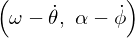

In [5]:
kin_diff = (omega - theta.diff(), alpha - phi.diff())
kin_diff

# Define Orientations

There are three reference frames. These are defined as such:

In [6]:
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')

The frames are oriented with respect to each other by simple revolute rotations. The following lines set the orientations:

In [7]:
A.orient(N, 'Axis', (theta, N.y))
B.orient(A, 'Axis', (phi, A.z))

# Define Positions

Three points are necessary to define the problem:

- $N_o$: The fixed point which the slender rod rotates about.
- $A_o$: The center of mass of the slender rod.
- $B_o$: The center of mass of the plate.

In [8]:
No = me.Point('No')
Ao = me.Point('Ao')
Bo = me.Point('Bo')

The two centers of mass positions can be set relative to the fixed point, $N_o$.

In [9]:
lA = (lB - h / 2) / 2
Ao.set_pos(No, lA * A.z)
Bo.set_pos(No, lB * A.z)

# Specify the Velocities

The generalized speeds should be used in the definition of the linear and angular velocities when using Kane's method. For simple rotations and the defined kinematical differential equations the angular rates are:

In [10]:
A.set_ang_vel(N, omega * N.y)
B.set_ang_vel(A, alpha * A.z)

Once the angular velocities are specified the linear velocities can be computed using the two point velocity thereom, starting with the origin point having a velocity of zero.

In [11]:
No.set_vel(N, 0)

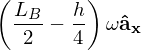

In [12]:
Ao.v2pt_theory(No, N, A)

In [13]:
Bo.v2pt_theory(No, N, A)

# Inertia

The central inertia of the symmetric slender rod with respect to its reference frame is a function of its length and its mass.

In [14]:
IAxx = sm.S(1) / 12 * mA * (2 * lA)**2
IAyy = IAxx
IAzz = 0

IA = (me.inertia(A, IAxx, IAyy, IAzz), Ao)

This gives the inertia tensor:

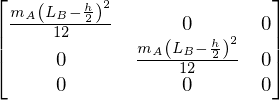

In [15]:
IA[0].to_matrix(A)

The central inerita of the symmetric plate with respect to its reference frame is a function of its width and height.

In [16]:
IBxx = sm.S(1)/12 * mB * h**2
IByy = sm.S(1)/12 * mB * (w**2 + h**2)
IBzz = sm.S(1)/12 * mB * w**2

IB = (me.inertia(B, IBxx, IByy, IBzz), Bo)

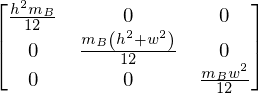

In [17]:
IB[0].to_matrix(B)

All of the information to define the two rigid bodies are now available. This information is used to create an object for the rod and the plate.

In [18]:
rod = me.RigidBody('rod', Ao, A, mA, IA)

In [19]:
plate = me.RigidBody('plate', Bo, B, mB, IB)

# Loads

The only loads in this problem is the force due to gravity that acts on the center of mass of each body. These forces are specified with a tuple containing the point of application and the force vector.

In [20]:
rod_gravity = (Ao, mA * g * N.z)
plate_gravity = (Bo, mB * g * N.z)

# Equations of motion

Now that the kinematics, kinetics, and inertia have all been defined the `KanesMethod` class can be used to generate the equations of motion of the system. In this case the independent generalized speeds, independent generalized speeds, the kinematical differential equations, and the inertial reference frame are used to initialize the class.

In [21]:
kane = me.KanesMethod(N, q_ind=(theta, phi), u_ind=(omega, alpha), kd_eqs=kin_diff)

The equations of motion are then generated by passing in all of the loads and bodies to the `kanes_equations` method. This produces $f_r$ and $f_r^*$.

In [22]:
bodies = (rod, plate)
loads = (rod_gravity, plate_gravity)

fr, frstar = kane.kanes_equations(bodies, loads)

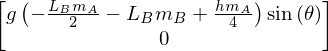

In [23]:
sm.trigsimp(fr)

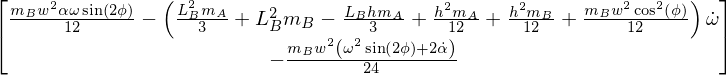

In [24]:
sm.trigsimp(frstar)

# Simulation

The equations of motion can now be simulated numerically. Values for the constants, initial conditions, and time are provided to the `System` class along with the symbolic `KanesMethod` object.

In [25]:
sys = System(kane)

In [26]:
sys.constants = {lB: 0.2, # meters
                 h: 0.1, # meters
                 w: 0.2, # meters
                 mA: 0.01, # kilograms
                 mB: 0.1, # kilograms
                 g: 9.81} # meters per second squared

In [27]:
sys.initial_conditions = {theta: np.deg2rad(45),
                          phi: np.deg2rad(0.5),
                          omega: 0,
                          alpha: 0}

In [28]:
sys.times = np.linspace(0, 10, 500)

The trajectories of the states are found with the `integrate` method.

In [29]:
x = sys.integrate()

The angles can be plotted to see how they change with respect to time given the initial conditions.

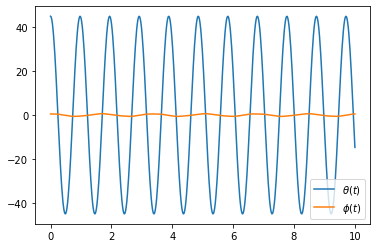

In [30]:
def plot():
    plt.figure()
    plt.plot(sys.times, np.rad2deg(x[:, :2]))
    plt.legend([sm.latex(s, mode='inline') for s in sys.coordinates])
plot()

# Chaotic Behavior

Now change the intial condition of the plat angle just slighty to see if the behvior of the system is similar.

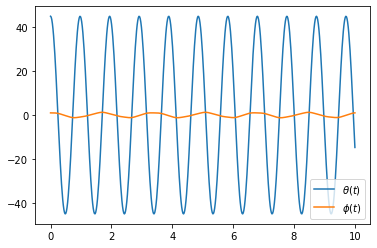

In [31]:
sys.initial_conditions[phi] = np.deg2rad(1.0)
x = sys.integrate()
plot()  

Seems all good, very similar behavior. But now set the rod angle to $90^\circ$ and try the same slight change in plate angle.

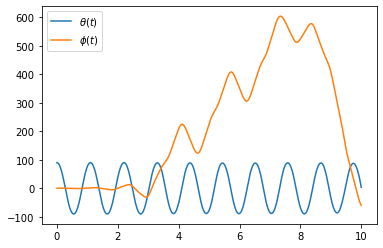

In [32]:
sys.initial_conditions[theta] = np.deg2rad(90)
sys.initial_conditions[phi] = np.deg2rad(0.5)
x = sys.integrate()
plot()

First note that the plate behaves wildly. What happens when the initial plate angle is altered slightly.

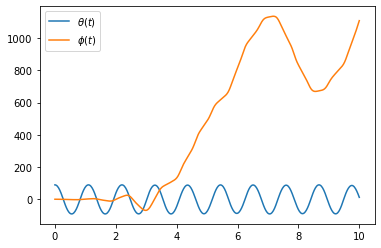

In [33]:
sys.initial_conditions[phi] = np.deg2rad(1.0)
x = sys.integrate()
plot()

The behavior does not look similar to the previous simulation. This is an example of chaotic behavior. The plate angle can not be reliably predicted because slight changes in the initial conditions cause the behavior of the system to vary widely.

# Visualization

Finally, the system can be animated by attached a cylinder and a plane shape to the rigid bodies. To properly align the coordinate axes of the shapes with the bodies, simple rotations are used.

In [34]:
rod_shape = Cylinder(2 * lA, 0.005, color='red')
plate_shape = Plane(h, w, color='blue')

v1 = VisualizationFrame('rod',
                        A.orientnew('rod', 'Axis', (sm.pi / 2, A.x)),
                        Ao,
                        rod_shape)

v2 = VisualizationFrame('plate',
                        B.orientnew('plate', 'Body', (sm.pi / 2, sm.pi / 2, 0), 'XZX'),
                        Bo,
                        plate_shape)

scene = Scene(N, No, v1, v2, system=sys)

`create_static_html()` is a quick way to generate all of the data needed for pythreejs.

In [35]:
scene.create_static_html(overwrite=True, silent=True)

For each visualizaion frame, the 4x4 transform matrices are obtained with:

In [36]:
rod_matrices = v1.evaluate_transformation_matrix(x, list(sys.constants.values()))
plate_matrices = v2.evaluate_transformation_matrix(x, list(sys.constants.values()))

Recreate the meshes in the animation with pythreejs. Make sure to use numbers, not symbols. Also, you need to uniquely name each mesh.

In [37]:
rod_mesh = pjs.Mesh(
    pjs.CylinderBufferGeometry(0.005, 0.005, sys.constants[lB] - sys.constants[h] / 2),
    pjs.MeshStandardMaterial(color='red'),
    name='rod')

plate_mesh = pjs.Mesh(pjs.PlaneBufferGeometry(sys.constants[h], sys.constants[w]),
                      pjs.MeshStandardMaterial(color='blue', side='DoubleSide'),
                      name="plate")

ceil_mesh = pjs.Mesh(pjs.BoxBufferGeometry(0.3, 0.2, 0.02),
                     pjs.MeshStandardMaterial(color='gray'),
                     name="ceiling")

In [38]:
x_arrow = pjs.ArrowHelper(dir=[1, 0, 0], length=0.25, color='blue')
y_arrow = pjs.ArrowHelper(dir=[0, 1, 0], length=0.25, color='red')
z_arrow = pjs.ArrowHelper(dir=[0, 0, 1], length=0.25,color='green')

To set the three.js transform matrices directly the `matrixAutoUpdate` must be disabled.

In [39]:
# Animation will not update without this set.
rod_mesh.matrixAutoUpdate = False
plate_mesh.matrixAutoUpdate = False

# Set initial position
rod_mesh.matrix = rod_matrices[0]
plate_mesh.matrix = plate_matrices[0]
ceil_mesh.position = [0.0, 0.0, -0.01]

Setup the scene and the renderer.

In [40]:
view_width = 600
view_height = 400
camera = pjs.PerspectiveCamera(position=[0.4, 0.4, 0.4], aspect=view_width/view_height)
key_light = pjs.DirectionalLight(position=[0, 10, 10])
ambient_light = pjs.AmbientLight()
scene_pjs = pjs.Scene(children=[rod_mesh, plate_mesh, ceil_mesh, x_arrow, y_arrow, z_arrow,
                                camera, key_light, ambient_light])
controller = pjs.OrbitControls(controlling=camera)
renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)

Display the scene:

In [41]:
renderer

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(0.4, 0.4, 0.4), quaternion=(0.0, 0.0, 0.0, 1.0), scale…

Create the key frame tracks. Make sure use `scene/<mesh name>.matrix` to access the sub component of the scene.

In [42]:
rod_track = pjs.VectorKeyframeTrack(name='scene/rod.matrix',
                                    times=list(sys.times),
                                    values=rod_matrices)
plate_track = pjs.VectorKeyframeTrack(name='scene/plate.matrix',
                                      times=list(sys.times),
                                      values=plate_matrices)

Create the animation:

In [43]:
clip = pjs.AnimationClip(tracks=[rod_track, plate_track], duration=sys.times[-1])
action = pjs.AnimationAction(pjs.AnimationMixer(scene_pjs), clip, scene_pjs)
action

AnimationAction(clip=AnimationClip(duration=10.0, tracks=(VectorKeyframeTrack(name='scene/rod.matrix', times=a…